In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load this file from inside the data folder
filename = 'sgqt_with_postprocessing_2-8qb.npz'

filepath = os.path.join('data', filename)
with np.load(filepath) as data:
    print('\n'.join(data['info']))
    
    NQs = data['NQs']
    Fids = data['Fids']
    Meas = data['Meas']
    
    N = np.shape(Fids)[1]
    Niter = np.shape(Fids)[2]

N, shots, and Niter are single integers in one array each.
NQs is the array of number of qubits.
Fids and Meas have shapes (len(NQs), N, Niter)


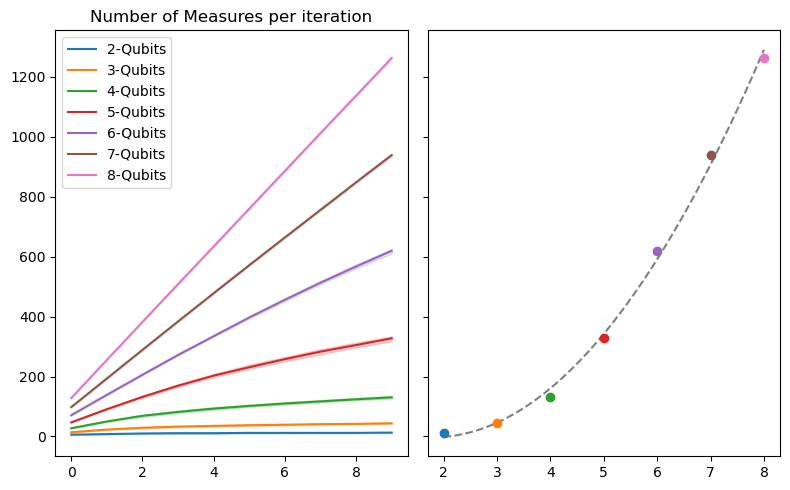

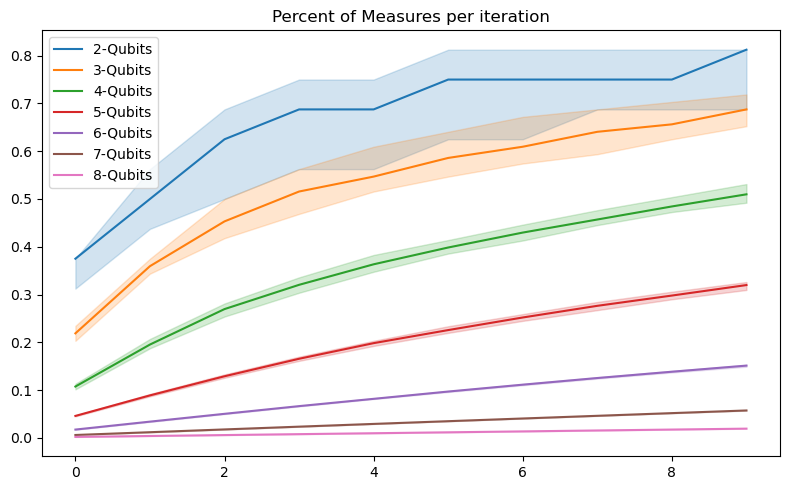

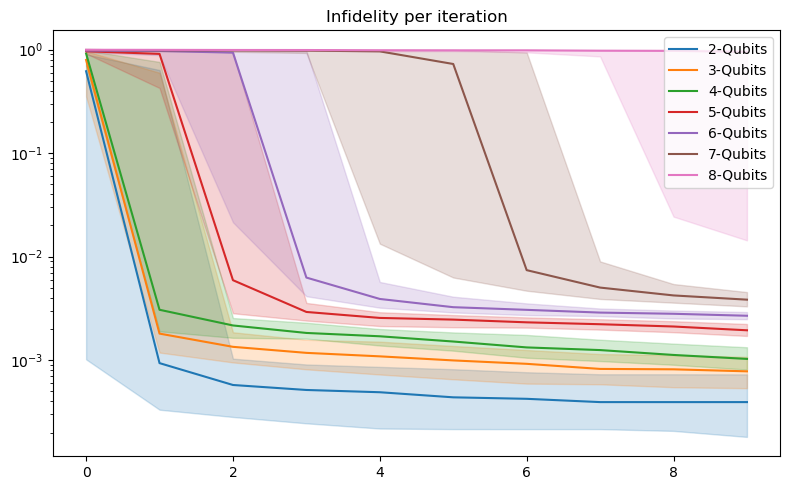

In [3]:
def compute_statistics(A, axis=1):
    mean = np.mean(A, axis=axis)
    std = np.std(A, axis=axis)
    median = np.median(A, axis=axis)    
    iqr = np.array([np.quantile(A, pt, axis=axis) for pt in [0.25, 0.75]])

    return mean, std, median, iqr

# Select statistics for plots
stats = 'median'

# Shading strength (0 means transparent)
alpha = 0.2

match stats:
    case 'mean':
        F, F_shade, _, _ = compute_statistics(Fids, axis=1)
        M, M_shade, _, _ = compute_statistics(Meas, axis=1)
        F_shade = (F - F_shade, F + F_shade) # mean +- std
        M_shade = (M - M_shade, M + M_shade)
    case 'median':
        _, _, F, F_shade = compute_statistics(Fids, axis=1)
        _, _, M, M_shade = compute_statistics(Meas, axis=1)
    case _:
        raise ValueError(f'stats can only be median or mean. Got {stats=}.')


# Crear primer conjunto de gráficos para Measures
fig0, ax0 = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
ax0[0].set_title("Number of Measures per iteration")

# Quadratic fit of Measurements
xfit = np.linspace(NQs.min(), NQs.max(), num=50) # Denser continuous line
fit_coefs = np.polyfit(NQs, M[:, -1], 2)
ax0[1].plot(xfit, np.polyval(fit_coefs, xfit), '--', color='gray', zorder=1)
ax0[1].set_xticks(NQs)

for j, NQ in enumerate(NQs):
    # Center line
    ax0[0].plot(range(Niter), M[j], label=f"{NQ}-Qubits")    
    color = ax0[0].get_lines()[j].get_color()
    # Deviation or IQR
    ax0[0].fill_between(range(Niter), M_shade[0][j], M_shade[1][j],
                        color = color,
                        alpha = alpha,)
    # Points for poly fit
    ax0[1].scatter(NQ, M[j, -1], color = color)


ax0[0].legend()
fig0.tight_layout()
# fig0.savefig('Measures.png')

# Crear primer conjunto de gráficos para Measures
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title("Percent of Measures per iteration")

colors = [line.get_color() for line in ax0[0].get_lines()]

for j, NQ in enumerate(NQs):
    total = 4 ** NQ
    
    ax1.plot(range(Niter), M[j] / total, label=f"{NQ}-Qubits", color=colors[j])
    
    ax1.fill_between(range(Niter),
                     M_shade[0][j] / total, M_shade[1][j] / total,
                     color = colors[j],
                     alpha = alpha,)
    

ax1.legend()
fig1.tight_layout()
# Guardar el primer conjunto de gráficos
# fig1.savefig('Measures.png')

# Crear segundo conjunto de gráficos para Measures
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_title("Infidelity per iteration")

for j, NQ in enumerate(NQs):
    ax2.semilogy(range(Niter), F[j], label=f"{NQ}-Qubits", color=colors[j])
    
    ax2.fill_between(range(Niter), F_shade[0][j], F_shade[1][j],
                     color = colors[j],
                     alpha = alpha,)

ax2.legend()
fig2.tight_layout()

# Guardar el segundo conjunto de gráficos
# fig2.savefig('Fidelities.png')